# 6. Convolutional Neural Networks

Until now, we simply discarded each image's *spatial* structure by flattening them into one-dimensional vectors, feeding them through a fully-connected MLP.

This chapter introduces *convolutional neural networks*(CNNs), a powerful family of neural networks that are designed for precisely this purpose.

image recognition, object detection, or semantic segmentation.

CNNs tend to be computationally efficient, both because they require fewer parameters than fully-connected architectures and because convolutions are easy to parallelize across GPU cores.

Consequently, practitioners often apply CNNs whenver possible, and increasingly they have emerged as credible competitors even on tasks with a one-dimensional sequence structure, such as audio, text, and time series analysis, where recurrent neural networks are conventionally used. Some clever adaptions of CNNs have also brought them to bear on graph-structured data and in recommender systems.

details : padding, stride, pooling layers used to aggregate information across adjacent spatial regions, the use of multiple channels at each layer, and a careful discussion of the structure of modern architecture.

## 6.1 From Fully-Connected Layers to Convolutions

* Invariance

CNNs systemize this idea of *spatial invariance*, exploiting it to learn useful representations with fewer parameters. (i.e. 'Where's Waldo')

1) *translation invariance* : In the earliest layers, our network should respond similarly to the same patch, regardless of where it appears in the image.

This implies that a shift in the input **X** should simply lead to a shift in the hidden representation **H**. This is only possible if **V** and **U** do not actually depend on (*i*, *j*). Following is *convolution*!

$$[𝐇]_{i,j} = 𝑢 + Σ_aΣ_b[𝐕]_{a,b}[𝐗]_{i+a, j+b}$$

We are effectively weighting pixels at (i+a, j+b) in the vicinity of location (i,j) with coefficients [V]a,b to obtain the value [H]i,j. Note that [V]a,b needs many fewer coefficients than [V]i,j,a,b since it no longer depends on the location within the image.

2) *locality* : The earliest layers of the network should focus on local regions, without regard for the contents of the image in distant regions. Eventually, these local representations can be aggregated to make predictions at the whole image level. Following is a *convolutional layer*! **V** is referred to as a *convolution kernel*, a filter, or simply the layer's *weights* that are often learnable parameters.

$$[𝐇]_{i,j} = 𝑢 + Σ_{a=-Δ}Σ_{b=-Δ}[𝐕]_{a,b}[𝐗]_{i+a, j+b}$$

The convolutional layer picks windows of a given size and weights intensities according to the filter **V**.

3) channel : In reality, images are not two-dimensional objects but rather third-order tensors, characterized by **height, width, and channel**.

To support multiple channels in both inputs (**X**) and hidden representations (**H**), we can add a fourth coordinate to **V** : [**V**]a,b,c,d.

$$[𝐇]_{i,j,d} = Σ_{a=-Δ}Σ_{b=-Δ}Σ_{c}[𝐕]_{a,b,c,d}[𝐗]_{i+a, j+b}$$

where *d* indexes the output channels in the hidden representations **H**. The above formula is the definition of a convolutional layer for multiple channels, where **V** is a kernel or filter of the layer.

We need to figure out how to combine all the hidden representations to a single output, e.g., whether there is a Waldo *anywhere* in the image. We also need to decide how to compute things efficiently, how to combine multiple layers, appropriate activation functions, and how to make reasonable design choices to yield networks that are effective in practice.

## Summary
* Translation invariance in images implies that all patches of an image will be treated in the same manner.

* Locality means that only a small neighborhood of pixels will be used to compute the corresponding hidden representations.

* In image processing, convolutional layers typically require many fewer parameters than fully-connected layers.

* CNNs are a special family of neural networks that contain convolutional layers.

* Channels on input and output allow our model to capture multiple aspects of image at each spatial location.

## 6.2 Convolutions for Images

1) The cross-correlation operation

shape of tensor : 3 x 3
kernel : 2 x 2

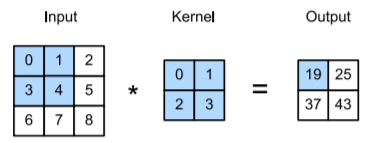

first element of output : 0 x 0 + 1 x1 + 3 x 2 + 4 x 3 = 19

multipled elementwise

In [ ]:
pip install d2l==0.14.2

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def corr2d(X, K):
  """Compute 2D cross-correlation."""
  h, w = K.shape
  Y = torch.zeros((X.shape[0] - h  + 1, X.shape[1] - w + 1)) # output shape
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
  return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0] ,[3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

A convolutional layer cross-correlates the input and kernel and adds a scalar bias to produce an output. The two parameters of a convolutional layer are the kernel and the scalar bias. When training models based on convolutional layers, we typically initialize the kerenels randomly, just as we would with a fully-connected layer.

In [ ]:
class Conv2D(nn.Module):
  def __init__(self, kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size))
    self.bias = nn.Parameter(torch.zeros(1))
  
  def forward(self, x):
    return corr2d(x, self.weight) + self.bias

In [ ]:
# black(0), white(1)
X = torch.ones((6,8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0, -1.0]])

In [ ]:
# we detect 1 for the edge from white to black and -1 for the edge from black to white. All other outputs take value 0.
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
corr2d(X.t(), K) # the kernel K only detects vertical edges

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
# For the sake of simplicity, in the following we use the built-in class for two-dimensional convolutional layers and ignore the bias.

# Construct a two-dimensional convolutional layer with 1 output channel and a kernel of shape (1,2).
# For the sake of simplicity, we ignore the bias here
conv2d = nn.Conv2d(1,1, kernel_size = (1, 2), bias = False)

# The two-dimensional convolutional layer uses four-dimensional input and output in the format of (example, channle, height, weight), where the batch size(number of examples in batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2 # Learning rate

In [ ]:
for i in range(10):
  Y_hat = conv2d(X)
  l = (Y_hat - Y) ** 2
  conv2d.zero_grad()
  l.sum().backward()
  # Update the kernel
  conv2d.weight.data[:] -= lr * conv2d.weight.grad
  if (i+1) % 2 == 0:
    print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 9.523
epoch 4, loss 2.194
epoch 6, loss 0.612
epoch 8, loss 0.203
epoch 10, loss 0.075


In [ ]:
conv2d.weight.data.reshape((1, 2))
# Indeed, the learned kernel tensor is remarkably close to the kernel tensor K we defined earlier.

tensor([[ 0.9590, -1.0134]])

## Summary
* The core computation of a two-dimensional convolutional layrer is a two-dimensional cross-correlation operation. In its simplest form, this performs a cross-correlation operation on the two-dimensional input data and kernel and then adds a bias.

* We can design a kernel to detect edges in images.

* We can learn the kernel's parameters from data.

* With kernels learned from data, the outputs of convolutional layers remain unaffected regardless of such layers' performed operations (either stric convolution or cross-correlation).

* When any element in a feature map needs a larger receptive field to detect broader features on the input, a deeper network can be considered.

## 6.3 Padding and Stride

* Padding : dealing with problem that we tend to lose pixels on the perimeter of our image.
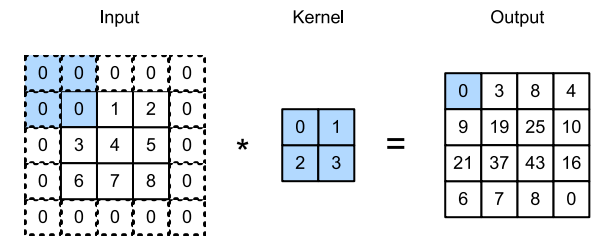

In [4]:
# In the following example, we create a two-dimensional convolutional layer with a height and width of 3 and apply 1 pixel of padding on all sides.
# Given an input with a height and width of 8, we find that the height and width of the output is also 8.

# We define a convenience function to calculate the convolutional layer.
# This function initializes the convolutional layer weights and performs corresponding dimensionality elevations and reductions on the input and output.
def comp_conv2d(conv2d, X):
  # Here (1, 1) indicates that the batch size and the number of channels are both 1
  X = X.reshape((1, 1) + X.shape)
  Y = conv2d(X)
  # Exclude the first two dimensions that do not interest us : examples and channels
  return Y.reshape(Y.shape[2:])

# Note that here 1 row or column is padded on either side, so a total of 2 rows or columns are added
conv2d = nn.Conv2d(1, 1, kernel_size = 3, padding = 1)
X = torch.rand(size = (8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [5]:
# Here, we use a convolution kernel with a height of 5 and a width of 3.
# The padding numbers on either side of the height and width are 2 and 1, respectively.
conv2d = nn.Conv2d(1, 1, kernel_size = (5, 3), padding = (2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

* stride

We refer to the number of rows and columns traversed per slide as the *stride*.
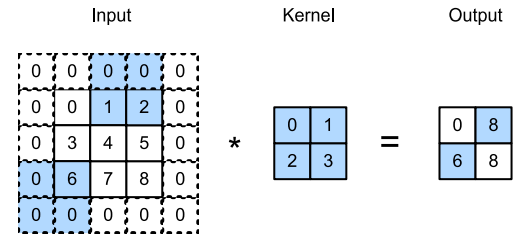

Cross-correlation with strides of 3 and 2 for height and width, repectively.

output shape:

$$[(n_h - k_h + p_h +s_h)/s_h] 𝗑 [(n_w -k_w + p_w + s_w)/s_w] $$

In [6]:
conv2d = nn.Conv2d(1, 1, kernel_size = 3, padding = 1, stride = 2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [7]:
conv2d = nn.Conv2d(1, 1, kernel_size = (3, 5), padding = (0, 1), stride = (3,4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

By default, the padding is 0 and the stride is 1.

In practice, we rarely use inhomogeneous strides or padding, i.e., we usually have p_h = p_w and s_h = s_w.

## Summary

* Padding can increase the height and width of the output. This is often used to give the output the same height and width as the input.

* The stride can reduce the resolution of the output, for example reducing the height and width of the output to only 1/n of the height and width of the input (n is an integer greater than 1).

* Padding and stride can be used to adjust the dimensionality of the data effectively.

## 6.4 Multiple Input and Multiple Output Channels

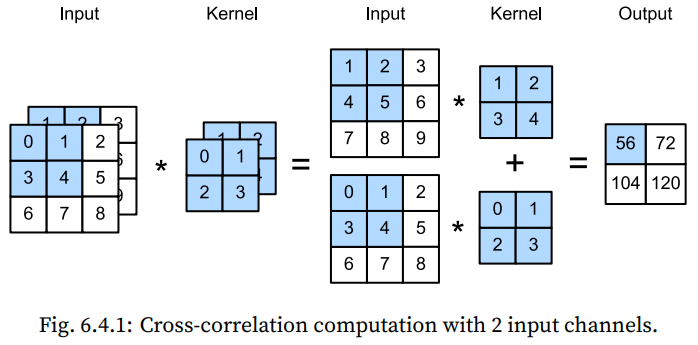

In [8]:
def corr2d_multi_in(X, K):
  # First, iterate through the 0th dimension (channel dimension) of `X` and `K`. Then, add them together
  return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [9]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]
                  ])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]
                  
])

In [10]:
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [12]:
def corr2d_multi_in_out(X, K):
  # Iterate through the 0th dimension of `K`, and each time, perform cross-correlation operations with input `X`.
  # All of the results are stacked together.
  return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [13]:
K = torch.stack((K, K+1, K+2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [14]:
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

* 1x1 Convolutional layer

1x1 convolutional layers are popular operations that are sometimes included in the designs of complex deep networks

In [15]:
def corr2d_multi_in_out_1x1(X, K):
  c_i, h, w = X.shape
  c_o = K.shape[0]
  X = X.reshape((c_i, h*w))
  K = K.reshape((c_o, c_i))
  # Matrix multiplication in the fully-connected layer
  Y = torch.matmul(K, X)
  return Y.reshape((c_o, h, w))

In [16]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [17]:
Y1 = corr2d_multi_in_out_1x1(X,K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1-Y2).sum()) < 1e-6

## Summary
* Multiple channels can be used to extend the model parameters of the convolutional layer.

* The 1x1 convolutional layer is equivalent to the fully-connected layer, when applied on a per pixel basis.

* The 1x1 convolutional layer is typically used to adjust the number of channels between network layers and to control model complexity.

## 6.5 Pooling

* maximum pooling, average pooling

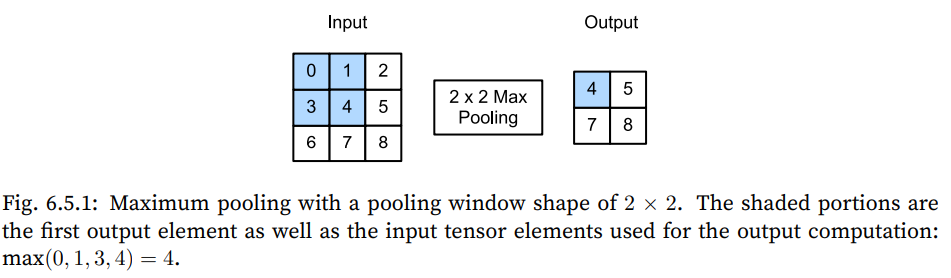

In [19]:
# Here, we have no kernel, computing the outputs as either the maximum or the average of each region in the input.
def pool2d(X, pool_size, mode = 'max'):
  p_h, p_w = pool_size
  Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if mode == 'max':
        Y[i, j] = X[i:i+p_h, j:j+p_w].max()
      elif mode == 'avg':
        Y[i, j] = X[i:i+p_h, j:j+p_w].mean()
  return Y

In [20]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2,2))

tensor([[4., 5.],
        [7., 8.]])

In [21]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [22]:
X = torch.arange(16, dtype = torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [23]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [24]:
pool2d = nn.MaxPool2d(3, padding = 1, stride = 2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [25]:
pool2d = nn.MaxPool2d((2, 3), stride = (2, 3), padding = (0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

* Multiple Channels

When processing multi-channel input data, the pooling layer pools each input channel separately, rather than summing the inputs up over channels as in a convolutional layer.

This means that the number of output channels for the pooling layer is the same as the number of input channels.

In [26]:
X = torch.cat((X, X+1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [27]:
pool2d = nn.MaxPool2d(3, padding = 1, stride = 2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## Summary
* Taking the input elements in the pooling window, the maximum pooling operation assigns the maximum value as the output and the average pooling operation assigns the average value as the output.

* One of the major benefits of a pooling layer is to alleviate the excessive sensitivity of the convolutional layer to location.

* We can specify the padding and stride for the pooling layer.

* Maximum pooling, combined with a stride larger than 1 can be used to reduce the spatial dimensions(e.g., width and height)

* The pooling layer's number of output channels is the same as the number of input channels.

## 6.6 Convolutional Neural Networks(LeNet)

As an additional benefit of replacing fully-connected layers with convolutional layers, we will enjoy more parsimonious models that require far fewer parameters.

LeNet(LeNet-5) consists of two parts:
(1) a convolutional encoder consisting of two convolutional layers

(2) a dense block consisting of three fully-connected layers

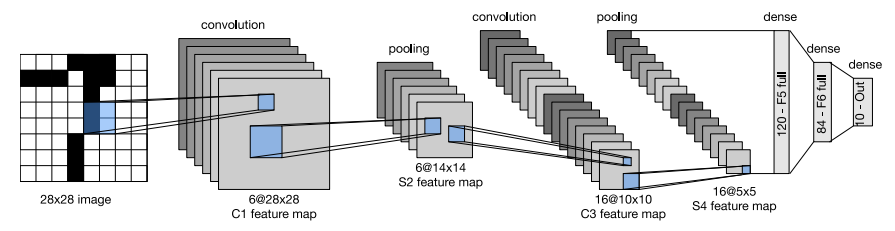

In order to pass output from the convolutional block to the dense block, we must **flatten** each example in the minibatch.

In other words, we take this four-dimensional input and transform it into the two-dimensional input expected by fully-connected layers : as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch and the second to give the flat vector representation of each example.

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size = 5, padding = 2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(6, 16, kernel_size = 5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

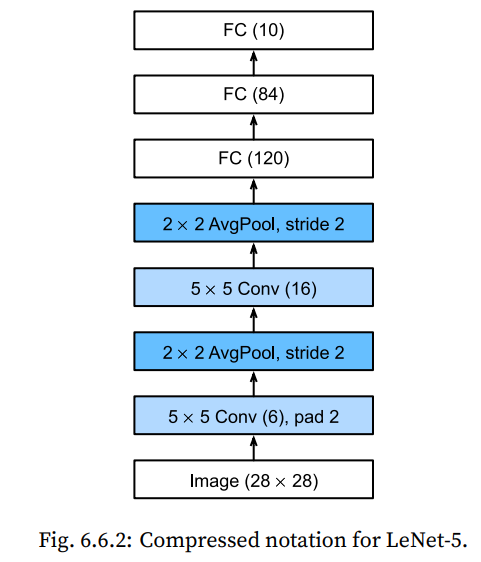

In [8]:
X = torch.rand(size = (1, 1, 28, 28), dtype = torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


Note that the height and width of the representation at each layer throughout the convolutional block is reduced(compared with the previous layer).

...

Finally, each fully-connected layer reduces dimensionality, finally emitting an output whose dimension matches the number of classes.

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size = batch_size)

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device = None):
  """Compute the accuracy for a model on a dataset using a GPU."""
  if isinstance(net, nn.Module):
    net.eval() # Set the model to evaluation mode
    if not device:
      device = next(iter(net.parameters())).device
  # No. of correct predictions, no. of predictions
  metric = d2l.Accumulator(2)

  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        # Required for BERT Fine-tuning (to be covered later)
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X), y), y.numel()) #numel : 원소 개수
  return metric[0] / metric[1]

In [5]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  """Train a model with a GPU (defined in Chapter 6)."""
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  print('training on', device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr = lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel = 'epoch', xlim = [1, num_epochs], legend = ['train loss', 'train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)
  for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy no. of examples
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i+1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch+(i+1) / num_batches, (train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch+1, (None, None, test_acc))
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec'
        f'on {str(device)}')

loss 0.500, train acc 0.809, test acc 0.763
20968.4 examples/secon cuda:0


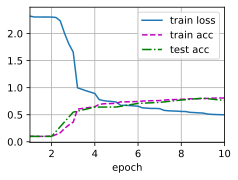

In [9]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Summary
* A CNN is a network that employs convolutional layers.

* In a CNN, we interleave convolutions, nonlinearities, and (often) pooling operations.

* In a CNN, convolutional layers are typically arranged so that they gradually decrease the spatial resolution of the representations, while increasing the number of channels.

* In traditional CNNs, the representations encoded by the convolutional blocks are processed by one or more fully-connected layers prior to emitting output.

* LeNet was arguably the first successful deployment of such a network.